# 🌐 Connect Colab to Google Drive

In [1]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/My Drive/Progetto AN2DL

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1E-vTKoRQdfaM-gJ1ejZEYjDrQK6K2Mmu/Progetto AN2DL


# ⚙️ Import Libraries

In [2]:
%env PYTHONHASHSEED=random
!pip install keras-cv # Install the missing module

env: PYTHONHASHSEED=random
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 45.0 MB/s eta 0:00:00


In [3]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from PIL import Image
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import requests
from io import BytesIO
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#import keras.src.engine
#import tensorflow_addons as tfa
#from torch_optimizer import Ranger


# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.1


In [4]:
import keras_cv.layers

# ⏳ Load the Data

In [5]:
#Load the training data
data = np.load('training_set.npz')
X = data['images']
y = data['labels']

In [6]:
# Print the shapes of the loaded datasets
print("Data Shape:", X.shape)
print("Label Shape:", y.shape)

Data Shape: (13759, 96, 96, 3)
Label Shape: (13759, 1)


##🔎 Inspect Data

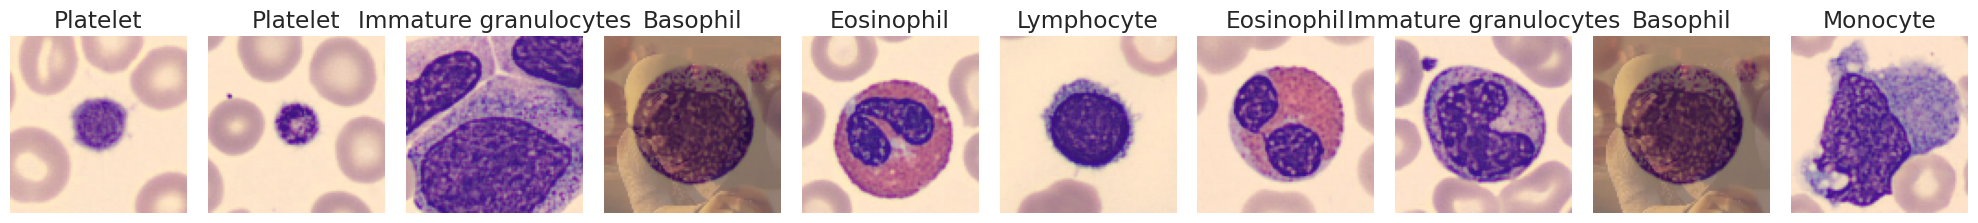

In [7]:
# Import other libraries
import random

import matplotlib.pyplot as plt
labels = {0:'Basophil', 1:'Eosinophil', 2:'Erythroblast', 3:'Immature granulocytes', 4:'Lymphocyte', 5:'Monocyte', 6:'Neutrophil', 7:'Platelet'}

# Save unique labels
unique_labels = list(labels.values())

# Display a sample of images from the training-validation dataset
num_img = 10
random_indices = random.sample(range(len(X)), num_img)

fig, axes = plt.subplots(1, num_img, figsize=(20, 20))

# Iterate through the selected number of images
for i, idx in enumerate(random_indices):
    ax = axes[i % num_img]
    ax.imshow(np.squeeze(X[idx]), vmin=0., vmax=1.)
    ax.set_title(f'{labels[y[idx][0]]}')
    ax.axis('off')

# Adjust layout and display the images
plt.tight_layout()
plt.show()

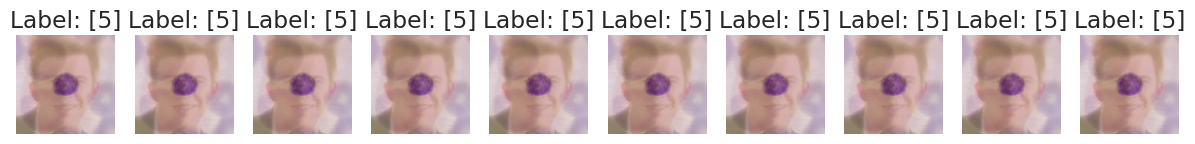

In [8]:
# Extract the last 10 images of the dataset
num_images = 10

# Extract the last 10 images and their corresponding labels
X_last_images = X[-num_images:]
y_last_labels = y[-num_images:]

# Plot the last images with their labels
plt.figure(figsize=(15, 3))  # Set the figure size

for i in range(num_images):
    plt.subplot(1, num_images, i + 1)  # Create a subplot for each image
    plt.imshow(X_last_images[i], cmap='gray')  # Display the image
    plt.title(f'Label: {y_last_labels[i]}')  # Set the title as the label
    plt.axis('off')  # Turn off the axis

plt.show()  # Show the plot

#🧹 Clean the Data

##🕵 Detect duplicates

In [9]:
from collections import defaultdict

def dhash(image, hash_size=8):
    # Resize the image to (hash_size+1, hash_size) to compute the difference
    # Use Image.Resampling.LANCZOS instead of Image.ANTIALIAS
    resized = image.resize((hash_size + 1, hash_size), Image.Resampling.LANCZOS).convert('L')

    # Convert the PIL Image to a NumPy array
    resized_np = np.array(resized)

    # Now you can use array slicing
    diff = resized_np[:, 1:] > resized_np[:, :-1]  # Compute the difference hash

    # Convert the hash to an integer value
    return sum([2 ** i for (i, v) in enumerate(diff.flatten()) if v])

# Dictionary to hold unique image hashes
hash_dict = defaultdict(list)

# Loop through images and generate hashes
for i, img in enumerate(X):
    # Convert the image to a PIL Image for hashing
    pil_img = Image.fromarray(img)
    image_hash = dhash(pil_img)

    # Store the index of the image in a list for that hash value
    hash_dict[image_hash].append(i)

# Extract duplicate images based on hash_dict entries with more than one image
duplicates = {hash_val: indices for hash_val, indices in hash_dict.items() if len(indices) > 1}

# Dizionario per memorizzare gli indici dei duplicati
duplicates = {hash_val: indices for hash_val, indices in hash_dict.items() if len(indices) > 1}

# Print the indeces of the duplicates
for hash_val, indices in duplicates.items():
    print(f"Indici delle immagini duplicate: {indices}")

Indici delle immagini duplicate: [120, 4761]
Indici delle immagini duplicate: [810, 11026]
Indici delle immagini duplicate: [1074, 3440]
Indici delle immagini duplicate: [3052, 11566]
Indici delle immagini duplicate: [3328, 11575]
Indici delle immagini duplicate: [5466, 11856]
Indici delle immagini duplicate: [7953, 10734]
Indici delle immagini duplicate: [8117, 9084]
Indici delle immagini duplicate: [11959, 11960, 11961, 11962, 11963, 11964, 11965, 11966, 11967, 11968, 11969, 11970, 11971, 11972, 11973, 11974, 11975, 11976, 11977, 11978, 11979, 11980, 11981, 11982, 11983, 11984, 11985, 11986, 11987, 11988, 11989, 11990, 11991, 11992, 11993, 11994, 11995, 11996, 11997, 11998, 11999, 12000, 12001, 12002, 12003, 12004, 12005, 12006, 12007, 12008, 12009, 12010, 12011, 12012, 12013, 12014, 12015, 12016, 12017, 12018, 12019, 12020, 12021, 12022, 12023, 12024, 12025, 12026, 12027, 12028, 12029, 12030, 12031, 12032, 12033, 12034, 12035, 12036, 12037, 12038, 12039, 12040, 12041, 12042, 12043, 

In [10]:
# Contatore per duplicati per etichetta
duplicate_labels_count = {}

for hash_val, indices in duplicates.items():
    for idx in indices:
        # Conta i duplicati per etichetta
        # Extract the scalar value from the NumPy array
        label = y[idx].item()  # or label = y[idx][0] if y[idx] is a 1D array
        if label in duplicate_labels_count:
            duplicate_labels_count[label] += 1
        else:
            duplicate_labels_count[label] = 1

print("\nNumber of duplicates for label:")

for label, count in duplicate_labels_count.items():
    print(f"Label {label}: {count} duplicati")


Number of duplicates for label:
Label 3: 206 duplicati
Label 0: 204 duplicati
Label 1: 204 duplicati
Label 5: 402 duplicati
Label 2: 200 duplicati
Label 4: 200 duplicati
Label 6: 200 duplicati
Label 7: 200 duplicati


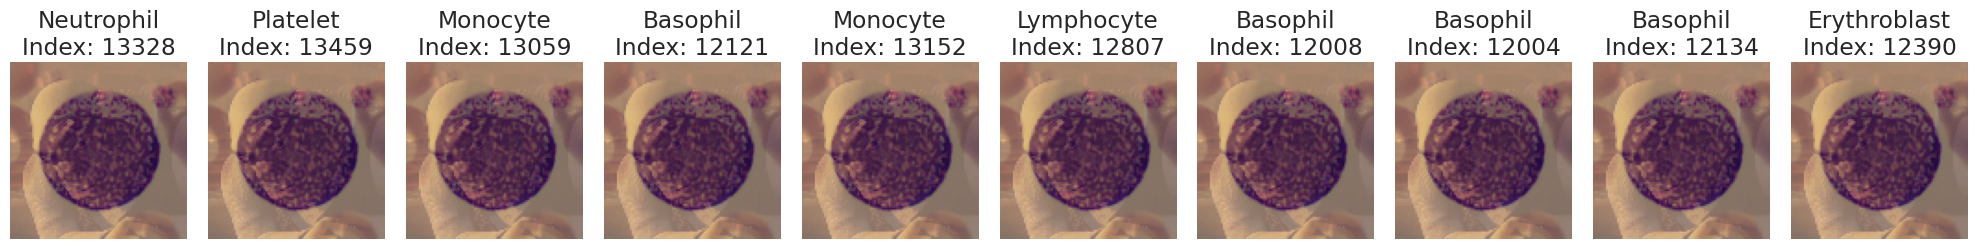

In [11]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Dizionario delle label
labels = {0: 'Basophil', 1: 'Eosinophil', 2: 'Erythroblast', 3: 'Immature granulocytes', 4: 'Lymphocyte', 5: 'Monocyte', 6: 'Neutrophil', 7: 'Platelet'}

# Estrai tutti gli indici delle immagini duplicate in una singola lista
duplicate_indices = [idx for indices in duplicates.values() for idx in indices]

# Numero di immagini da visualizzare
num_img = 10

# Seleziona 10 indici casuali tra le immagini duplicate, senza superare il numero totale di duplicate
sampled_duplicate_indices = random.sample(duplicate_indices, min(num_img, len(duplicate_indices)))

# Imposta il grafico con 1 riga e `num_img` colonne
fig, axes = plt.subplots(1, num_img, figsize=(20, 20))

# Visualizza le immagini duplicate selezionate
for i, idx in enumerate(sampled_duplicate_indices):
    ax = axes[i % num_img]
    ax.imshow(np.squeeze(X[idx]), vmin=0., vmax=1.)
    ax.set_title(f'{labels[y[idx][0]]}\nIndex: {idx}')
    ax.axis('off')

# Aggiusta il layout e mostra le immagini
plt.tight_layout()
plt.show()


##❌ Eliminate duplicates

In [12]:
duplicate_indices = set(idx for indices in duplicates.values() for idx in indices)

all_indices = set(range(len(X)))
unique_indices = list(all_indices - duplicate_indices)

X_filtered = X[unique_indices]
y_filtered = y[unique_indices]

# Verifica: mostra la dimensione del dataset originale e di quello senza duplicati
print(f"Original dimension of images: {X.shape}")
print(f"Dimension of images without duplicates: {X_filtered.shape}")
print(f"Original dimension of labels: {y.shape}")
print(f"Dimension of labesls without duplicates: {y_filtered.shape}")

Original dimension of images: (13759, 96, 96, 3)
Dimension of images without duplicates: (11943, 96, 96, 3)
Original dimension of labels: (13759, 1)
Dimension of labesls without duplicates: (11943, 1)


##🔎 New Data inspection


In [13]:
# Inspect the target
print('Counting occurrences of target classes:')
print(pd.DataFrame(y_filtered, columns=['digit'])['digit'].value_counts())

Counting occurrences of target classes:
digit
6    2330
1    2177
3    2020
7    1643
2    1085
5     991
4     849
0     848
Name: count, dtype: int64


## 💾 Save Filtered Data

In [14]:
# Save the new dataset
np.savez_compressed('data_filtered.npz', images=X_filtered, labels=y_filtered)


# ⌛ Load Already Filtered Data

In [15]:
# Load the new balanced training data
data = np.load('data_filtered.npz')
X = data['images']
y = data['labels']

# 🔄 Data Processing

We created the following code to allow flexibility in deciding whether to perform data augmentation, balance the classes using a custom split (e.g., setting a fixed number of images for each label to include in the validation set while applying data augmentation only to the images in the training set), and normalize the data.

In [16]:
test_size = 0.1
aug = True # Default value = True
bal = False # Default value = False
custom_split = bal # Use only if balancing the data
test_size_per_class = 100 # Used only if the data are balanced
norm = False # Normalization

In [17]:
import numpy as np
from sklearn.model_selection import train_test_split

def stratified_split_with_fixed_test_size(X, y, test_size_per_class=100, random_state=seed):
    """
    Divide il dataset in training e test set garantendo che il test set abbia un numero fisso di campioni per classe.

    Args:
        X (array-like): Dati (es., immagini o feature).
        y (array-like): Etichette associate (può essere scalare o one-hot).
        test_size_per_class (int): Numero fisso di campioni per classe nel test set.
        random_state (int): Seed per randomizzazione.

    Returns:
        X_train, X_val, y_train, y_val: Dataset divisi in training e test set.
    """
    # Check is the labels are in one-hot encoding format and converts to scalar if necessary
    if len(y.shape) > 1 and y.shape[1] > 1:
        y_classes = np.argmax(y, axis=1)
    else:
        y_classes = y

    # Find unique classes
    unique_classes = np.unique(y_classes)

    # Liste per i dati divisi
    X_train, X_val, y_train, y_val = [], [], [], []

    # Split for each class
    for cls in unique_classes:
        # Estrai i dati della classe corrente
        idx_class = np.where(y_classes == cls)[0]
        X_class = X[idx_class]
        y_class = y[idx_class]

        # Esegui uno split per garantire il test_size_per_class
        X_cls_train, X_cls_val, y_cls_train, y_cls_val = train_test_split(
            X_class, y_class, test_size=test_size_per_class, random_state=random_state
        )

        # Aggiungi i dati allo split generale
        X_train.append(X_cls_train)
        X_val.append(X_cls_val)
        y_train.append(y_cls_train)
        y_val.append(y_cls_val)

    # Concatena le liste per ottenere array numpy finali
    X_train = np.concatenate(X_train, axis=0)
    X_val = np.concatenate(X_val, axis=0)
    y_train = np.concatenate(y_train, axis=0)
    y_val = np.concatenate(y_val, axis=0)

    return X_train, X_val, y_train, y_val

In [18]:
if custom_split:
    # Training and Validation set
  X_train, X_val, y_train, y_val = stratified_split_with_fixed_test_size(
    X, y,
    test_size_per_class=test_size_per_class,
    random_state=seed)
else:
  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=seed, stratify=y)

In [19]:
# Show the dimensions of the different datasets
print(f"\nDimension of Training balanced set X: {X_train.shape}")
print(f"Dimension of Training balanced set y: {y_train.shape}")

print(f"\nDimension of Testing set X: {X_val.shape}")
print(f"Dimension of Testing set y: {y_val.shape}")


Dimension of Training balanced set X: (10748, 96, 96, 3)
Dimension of Training balanced set y: (10748, 1)

Dimension of Testing set X: (1195, 96, 96, 3)
Dimension of Testing set y: (1195, 1)


In [20]:
# Save original Training Dataset
X_train_0 = X_train
y_train_0 = y_train

In [21]:
def print_class_distribution(y, set_name="Dataset"):
    """
    Conta e stampa il numero di elementi per ciascuna classe nel dataset.

    Args:
        y (array-like): Array delle etichette (può essere scalare o one-hot).
        set_name (str): Nome del dataset (ad es., "Training Set").
    """
    # Controlla se le etichette sono in formato one-hot
    if len(y.shape) > 1 and y.shape[1] > 1:
        y_classes = np.argmax(y, axis=1)  # Converte le etichette one-hot in scalari
    else:
        y_classes = y  # Già in formato scalare

    # Conta gli elementi per classe
    unique_classes, counts = np.unique(y_classes, return_counts=True)
    print(f"Distribuzione delle classi nel {set_name}:")
    for cls, count in zip(unique_classes, counts):
        print(f"Classe {cls}: {count} campioni")
    print("\n")

# Stampa la distribuzione delle classi nel training set
print_class_distribution(y_train, set_name="Training Set")

# Stampa la distribuzione delle classi nel test set
print_class_distribution(y_val, set_name="Test Set")


Distribuzione delle classi nel Training Set:
Classe 0: 763 campioni
Classe 1: 1959 campioni
Classe 2: 976 campioni
Classe 3: 1818 campioni
Classe 4: 764 campioni
Classe 5: 892 campioni
Classe 6: 2097 campioni
Classe 7: 1479 campioni


Distribuzione delle classi nel Test Set:
Classe 0: 85 campioni
Classe 1: 218 campioni
Classe 2: 109 campioni
Classe 3: 202 campioni
Classe 4: 85 campioni
Classe 5: 99 campioni
Classe 6: 233 campioni
Classe 7: 164 campioni




# ♎  Training Set Balancing

In [22]:
# ImageDataGenerator for Balancing
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0,
    zoom_range=0,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

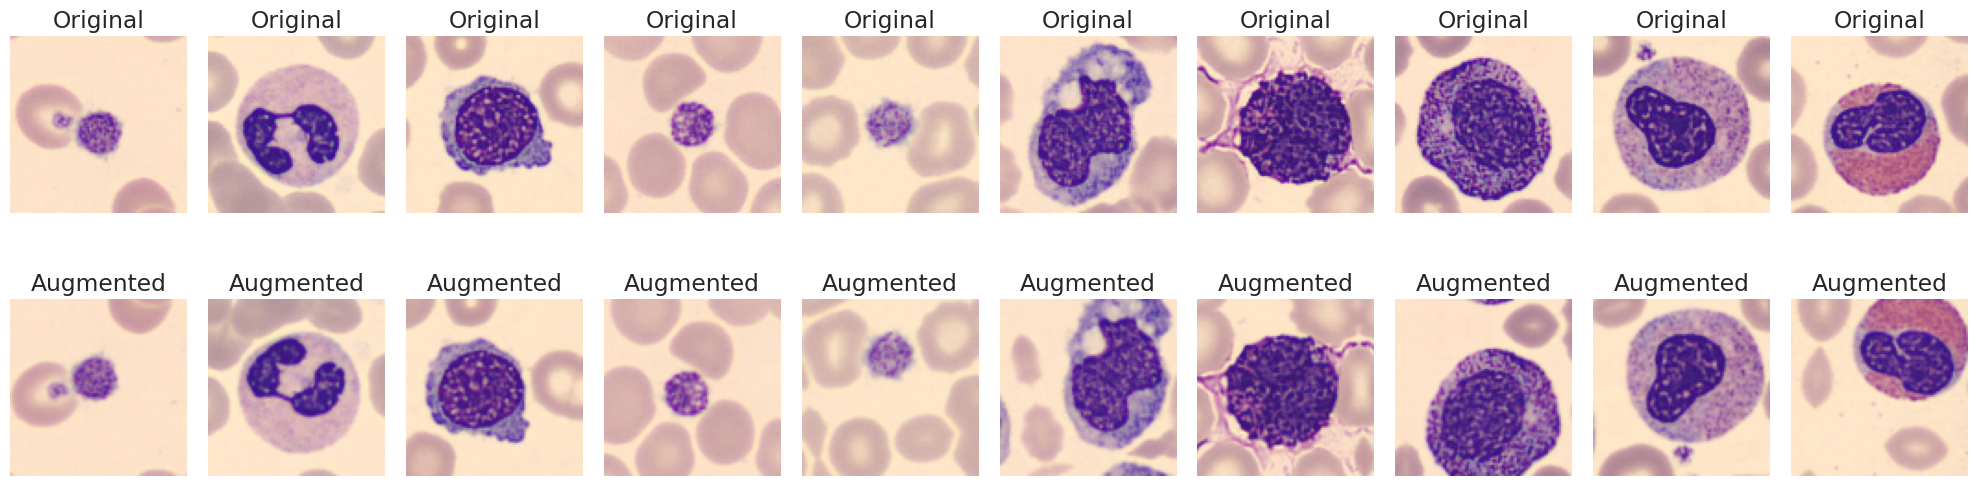

In [23]:
def display_images_with_augmentation(X_train, num_images=10, seed=42):
    """
    Mostra immagini originali e le loro versioni augmentate utilizzando ImageDataGenerator.

    Args:
        X_train: Dataset di immagini.
        num_images: Numero di immagini da mostrare.
        seed: Seed per randomizzazione.
    """
    np.random.seed(seed)  # Assicura che la selezione delle immagini sia riproducibile
    random_indices = np.random.choice(len(X_train), num_images, replace=False)

    # Seleziona immagini casuali da X_train
    images = X_train[random_indices]

    # Configura il plot
    fig, axes = plt.subplots(2, num_images, figsize=(20, 6))

    # Prima riga: immagini originali
    for i, img in enumerate(images):
        axes[0, i].imshow(np.squeeze(img))
        axes[0, i].axis('off')
        axes[0, i].set_title("Original")

    # Seconda riga: immagini augmentate
    for i, img in enumerate(images):
        # Genera un'immagine augmentata
        augmented_img = next(datagen.flow(np.expand_dims(img, axis=0), batch_size=1))[0]
        axes[1, i].imshow(np.squeeze(augmented_img/255))
        axes[1, i].axis('off')
        axes[1, i].set_title("Augmented")

    plt.tight_layout()
    plt.show()

# Esempio di utilizzo
display_images_with_augmentation(X_train, num_images=10)

In [24]:
def balance_dataset(X_train, y_train, datagen, augment_classes=[0, 1, 2, 3, 4, 5, 6, 7]):
    """
    Bilancia un dataset applicando l'augmentazione a classi specifiche.

    Parametri:
        X_train (np.array): Dati di input originali (immagini).
        y_train (np.array): Label corrispondenti.
        datagen (ImageDataGenerator): Generatore di dati per l'augmentazione.
        target_samples (int, opzionale): Numero di campioni target per ogni classe.
                                         Se non specificato, usa la cardinalità della classe più numerosa.
        augment_classes (list, opzionale): Lista delle classi da bilanciare.
                                           Se non specificato, bilancia tutte le classi presenti.

    Ritorna:
        X_train_balanced (np.array): Dati bilanciati.
        y_train_balanced (np.array): Label bilanciate.
    """
    unique, counts = np.unique(y_train, return_counts=True)
    max_samples = max(dict(zip(unique, counts)).values())
    target_samples = max_samples

    augment_indices = np.where(np.isin(y_train, augment_classes))[0]
    class_counts = pd.DataFrame(y_train, columns=['digit'])['digit'].value_counts()

    samples_needed = {}
    for class_label in augment_classes:
        current_count = class_counts.get(class_label, 0)
        if current_count < target_samples:
            samples_needed[class_label] = target_samples - current_count

    final_augmented_images = []
    final_augmented_labels = []

    for class_label, num_additional_samples in samples_needed.items():
        print(f"Processing class {class_label} with {num_additional_samples} samples needed")

        class_indices = np.where(y_train == class_label)[0]
        class_images = X_train[class_indices]

        augmented_images = []
        augmented_labels = []

        i = 0
        while i < num_additional_samples:
            for img in class_images:
                img = np.expand_dims(img, axis=0)
                for batch in datagen.flow(img, batch_size=1):
                    augmented_img = batch[0]
                    augmented_images.append(augmented_img)
                    augmented_labels.append(class_label)
                    i += 1
                    break
                if i >= num_additional_samples:
                    break
            if i >= num_additional_samples:
                break

        final_augmented_images.extend(augmented_images)
        final_augmented_labels.extend(augmented_labels)

    X_augmented = np.array(final_augmented_images)
    y_augmented = np.array(final_augmented_labels).reshape(-1, 1)

    X_train_balanced = np.concatenate((X_train, X_augmented), axis=0)
    y_train_balanced = np.concatenate((y_train, y_augmented), axis=0)

    print('New counts of train val classes after augmentation:')
    print(pd.DataFrame(y_train_balanced, columns=['digit'])['digit'].value_counts())

    return X_train_balanced, y_train_balanced

# 🔝Data Augmentation

In [25]:
rand_augmentation = keras_cv.layers.RandAugment(
    value_range=[0, 255],
    augmentations_per_image=1,
    magnitude=0.5,
    magnitude_stddev=0.15,
    rate=0.90,
    geometric=True,
    seed=seed
)

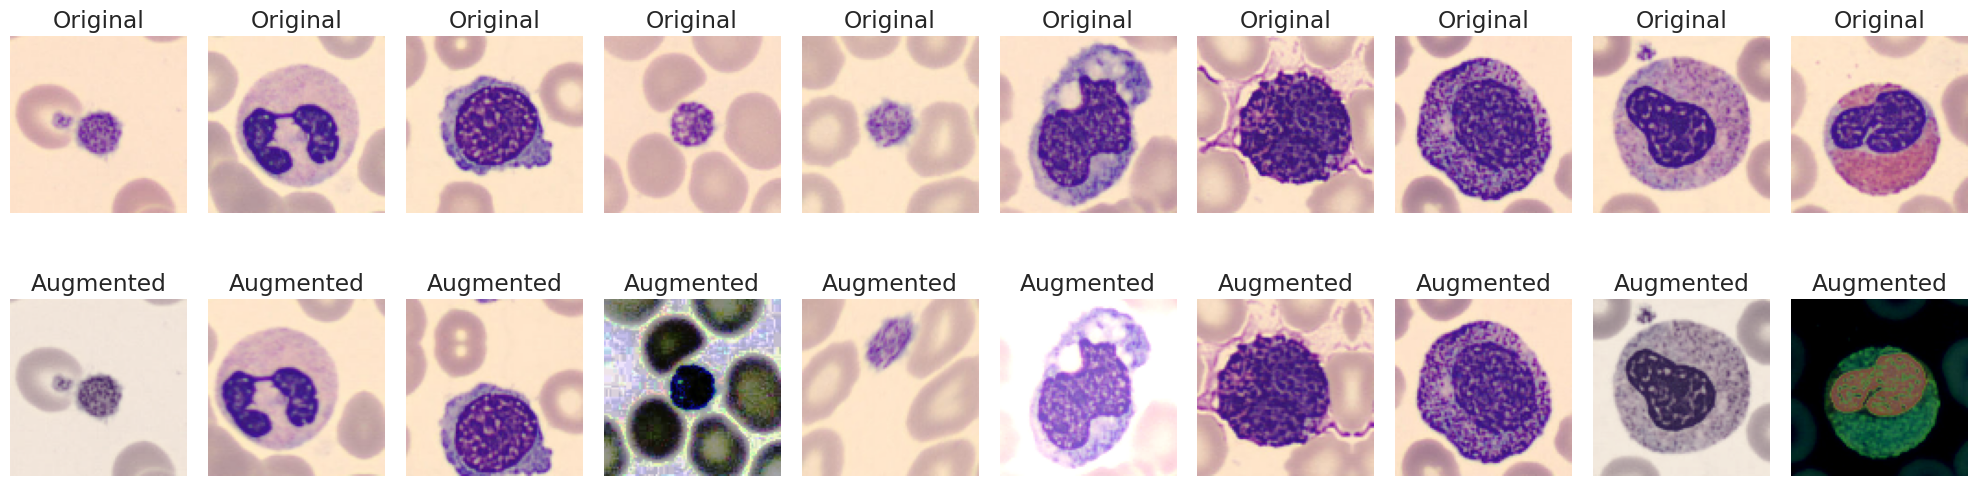

In [26]:
def display_images_with_augmentation(X_train, num_images=10, seed=seed):
    """
    Mostra immagini originali e le loro versioni augmentate utilizzando ImageDataGenerator.

    Args:
        X_train: Dataset di immagini.
        num_images: Numero di immagini da mostrare.
        seed: Seed per randomizzazione.
    """
    np.random.seed(seed)  # Assicura che la selezione delle immagini sia riproducibile
    random_indices = np.random.choice(len(X_train), num_images, replace=False)

    # Seleziona immagini casuali da X_train
    images = X_train[random_indices]

    # Configura il plot
    fig, axes = plt.subplots(2, num_images, figsize=(20, 6))

    # Prima riga: immagini originali
    for i, img in enumerate(images):
        axes[0, i].imshow(np.squeeze(img))
        axes[0, i].axis('off')
        axes[0, i].set_title("Original")

    # Seconda riga: immagini augmentate
    for i, img in enumerate(images):
        # Genera un'immagine augmentata
        augmented_img = rand_augmentation(img)
        axes[1, i].imshow(np.squeeze(augmented_img/255))
        axes[1, i].axis('off')
        axes[1, i].set_title("Augmented")

    plt.tight_layout()
    plt.show()

# Esempio di utilizzo
display_images_with_augmentation(X_train, num_images=10)

# ✍ Define Training Parameters and Data

In [27]:
if bal:
    X_train, y_train = balance_dataset(X_train, y_train)
if aug:
    X_train = rand_augmentation(X_train)
if norm:
  X_train = (X_train / 255).astype('float32')
  X_val = (X_val / 255).astype('float32')

In [28]:
# Convert labels to categorical format using one-hot encoding
y_train = tfk.utils.to_categorical(y_train)
y_val = tfk.utils.to_categorical(y_val)

In [29]:
# Learning rate: step size for updating the model's weights
learning_rate = 0.0001
print("Learning Rate:", learning_rate)

Learning Rate: 0.0001


In [30]:
# Show the dimensions of the different datasets
print(f"\nDimension of Training balanced set X: {X_train.shape}")
print(f"Dimension of Training balanced set y: {y_train.shape}")

print(f"\nDimension of Validation set X: {X_val.shape}")
print(f"Dimension of Validation set y: {y_val.shape}")


Dimension of Training balanced set X: (10748, 96, 96, 3)
Dimension of Training balanced set y: (10748, 8)

Dimension of Validation set X: (1195, 96, 96, 3)
Dimension of Validation set y: (1195, 8)


# 🧮 Define Network Parameters

In [31]:
# Input shape for the model
input_shape = X_train.shape[1:]

# Output shape for the model
output_shape = y_train.shape[1]

print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

Input Shape: (96, 96, 3)
Output Shape: 8


In [32]:
# Parameters for the Convolutational and Dense Blocks
units=128

In [33]:
# Batch size for training
batch_size = 128

# Print the defined parameters
#print("Epochs:", epochs)
print("Batch Size:", batch_size)

Batch Size: 128


# 🏗 Assembling the model

In [34]:
# Number of training epochs
epochs = 1000

# Define the patience value for early stopping
patience = 20

# Create an EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.01,
    mode='max',
    patience=patience,
    restore_best_weights=True
)

# Store the callback in a list
callbacks = [early_stopping]

First model that we tested:

In [35]:
def build_model_cnn(
    input_shape=input_shape,
    output_shape=output_shape,
    learning_rate=learning_rate,
    l2_lambda=5e-4,
    seed=seed,
    activation='relu',
):
    tf.random.set_seed(seed)

    # Regulizer and Initializer
    regularizer = tf.keras.regularizers.l2(l2_lambda)
    initializer = tf.keras.initializers.GlorotNormal(seed=seed)

    # Define the input layer
    input_layer = tf.keras.layers.Input(shape=input_shape, name='Input')

    x = tfkl.Conv2D(filters=32, kernel_size=3, padding='same', name='conv1')(input_layer)
    x = tfkl.Activation('relu', name='act1')(x)
    x = tfkl.MaxPooling2D(pool_size=2, name='mp1')(x)

    x = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='conv2')(x)
    x = tfkl.Activation('relu', name='act2')(x)
    x = tfkl.MaxPooling2D(pool_size=2, name='mp2')(x)

    x = tfkl.Flatten(name='flatten')(x)

    x = tfkl.Dense(units=output_shape, name='dense')(x)

    # Add output layer
    outputs = tfkl.Activation('softmax', name='softmax')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=outputs, name='CNN')

    # Compile the model
    loss = tfk.losses.CategoricalCrossentropy()
    optimizer = tfk.optimizers.Adam(learning_rate)
    metrics = ['accuracy']
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    # Return the model
    return model

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ Input (InputLayer)                  │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv1 (Conv2D)                      │ (None, 96, 96, 32)           │           896 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ act1 (Activation)                   │ (None, 96, 96, 32)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mp1 (MaxPooling2D)                  │ (None, 48, 48, 32)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv2 (Conv2D)                      │ (None, 48, 48, 64)           │        18,496 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ act2 (Activation)                   │ (None, 48, 48, 64)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mp2 (MaxPooling2D)                  │ (None, 24, 24, 64)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ flatten (Flatten)                   │ (None, 36864)                │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense (Dense)                       │ (None, 8)                    │       294,920 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ softmax (Activation)                │ (None, 8)                    │             0 │    -    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 314,312 (1.20 MB)

 Trainable params: 314,312 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

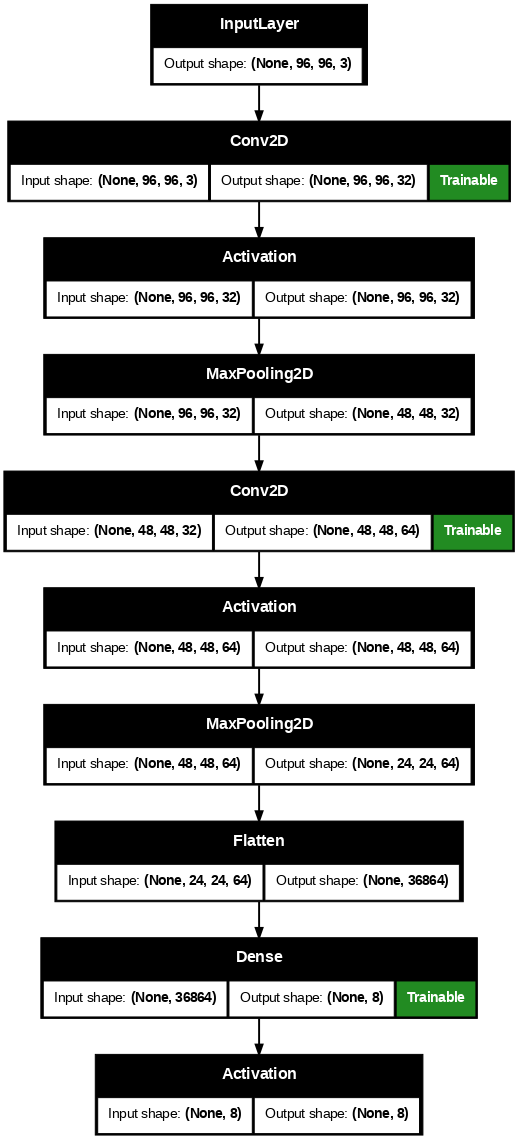

In [36]:
# Build the model with specified input and output shapes
model = build_model_cnn()

# Display a summary of the model architecture
model.summary(expand_nested=True, show_trainable=True)

# Plot the model architecture
tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

In [37]:
# Train the model with early stopping callback
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'Model1'+str(final_val_accuracy)+'.keras'
model.save(model_filename)

Epoch 1/1000
84/84 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step - accuracy: 0.1889 - loss: 64.1365 - val_accuracy: 0.4025 - val_loss: 4.6684
Epoch 2/1000
84/84 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.4017 - loss: 4.8862 - val_accuracy: 0.5289 - val_loss: 3.2128
Epoch 3/1000
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.5170 - loss: 3.2324 - val_accuracy: 0.6126 - val_loss: 2.1329
Epoch 4/1000
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.6093 - loss: 2.2045 - val_accuracy: 0.6586 - val_loss: 1.6940
Epoch 5/1000
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.6609 - loss: 1.6428 - val_accuracy: 0.7197 - val_loss: 1.3113
Epoch 6/1000
84/84 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.7200 - loss: 1.3288 - val_accuracy: 0.7205 - val_loss: 1.4194
Epoch 7/1000
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.7296 - loss: 1.2789 - val_accuracy: 0.8017 - val_loss: 0.8581
Epoch 8/1000
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.7687 - loss: 0.9886 - val_a

This is the second model that we tried:

In [38]:
 def build_model_mt(
    input_shape=input_shape,  # Shape of the input image, e.g., (96, 96, 3)
    output_shape=output_shape,  # Number of classes, e.g., 10
    learning_rate=learning_rate,
    seed=seed
):
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    inputs = tfkl.Input(shape=input_shape, name='Input')

    # Block 1
    x = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='conv1')(inputs)
    x = tfkl.Activation('relu', name='act1')(x)
    x = tfkl.MaxPooling2D(pool_size=2, name='mp1')(x)

    # Block 2
    x = tfkl.Conv2D(filters=128, kernel_size=3, padding='same', name='conv2')(x)
    x = tfkl.Activation('relu', name='act2')(x)
    x = tfkl.MaxPooling2D(pool_size=2, name='mp2')(x)

    # Block 3
    x = tfkl.Conv2D(filters=256, kernel_size=3, padding='same', name='conv3')(x)
    x = tfkl.Activation('relu', name='act3')(x)
    x = tfkl.MaxPooling2D(pool_size=2, name='mp3')(x)

    # Block 4
    x = tfkl.Conv2D(filters=512, kernel_size=3, padding='same', name='conv4')(x)
    x = tfkl.Activation('relu', name='act4')(x)
    x = tfkl.MaxPooling2D(pool_size=2, name='mp4')(x)

    # Block 5
    x = tfkl.Conv2D(filters=512, kernel_size=3, padding='same', name='conv5')(x)
    x = tfkl.Activation('relu', name='act5')(x)
    x = tfkl.MaxPooling2D(pool_size=2, name='mp5')(x)

    # Apply Global Average Pooling instead of Flatten + Dense layers
    x = tfkl.GlobalAveragePooling2D(name='gap')(x)

    # Output layer
    outputs = tfkl.Dense(units=output_shape, activation='softmax', name='softmax')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=inputs, outputs=outputs, name='VGG_with_GAP')

    # Compile the model
    loss = tfk.losses.CategoricalCrossentropy()
    optimizer = tfk.optimizers.Adam(learning_rate)
    metrics = ['accuracy']
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    # Return the model
    return model

Model: "VGG_with_GAP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ Input (InputLayer)                  │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv1 (Conv2D)                      │ (None, 96, 96, 64)           │         1,792 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ act1 (Activation)                   │ (None, 96, 96, 64)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mp1 (MaxPooling2D)                  │ (None, 48, 48, 64)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv2 (Conv2D)                      │ (None, 48, 48, 128)          │        73,856 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ act2 (Activation)                   │ (None, 48, 48, 128)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mp2 (MaxPooling2D)                  │ (None, 24, 24, 128)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv3 (Conv2D)                      │ (None, 24, 24, 256)          │       295,168 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ act3 (Activation)                   │ (None, 24, 24, 256)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mp3 (MaxPooling2D)                  │ (None, 12, 12, 256)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv4 (Conv2D)                      │ (None, 12, 12, 512)          │     1,180,160 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ act4 (Activation)                   │ (None, 12, 12, 512)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mp4 (MaxPooling2D)                  │ (None, 6, 6, 512)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv5 (Conv2D)                      │ (None, 6, 6, 512)            │     2,359,808 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ act5 (Activation)                   │ (None, 6, 6, 512)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mp5 (MaxPooling2D)                  │ (None, 3, 3, 512)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ gap (GlobalAveragePooling2D)        │ (None, 512)                  │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ softmax (Dense)                     │ (None, 8)                    │         4,104 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 3,914,888 (14.93 MB)

 Trainable params: 3,914,888 (14.93 MB)

 Non-trainable params: 0 (0.00 B)

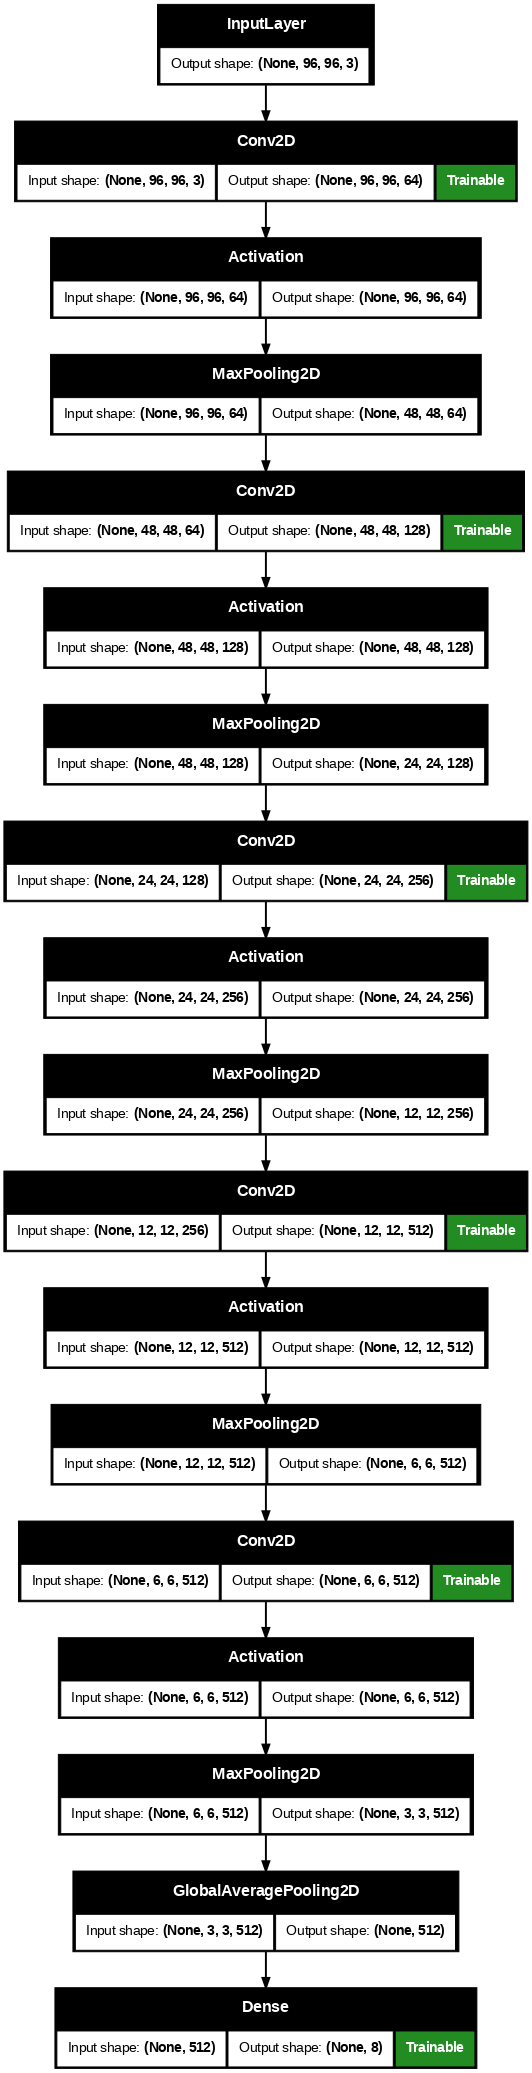

In [39]:
# Build the model with specified input and output shapes
model = build_model_mt()

# Display a summary of the model architecture
model.summary(expand_nested=True, show_trainable=True)

# Plot the model architecture
tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

In [40]:
# Train the model with early stopping callback
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'Model2'+str(final_val_accuracy)+'.keras'
model.save(model_filename)

Epoch 1/1000
84/84 ━━━━━━━━━━━━━━━━━━━━ 39s 314ms/step - accuracy: 0.1920 - loss: 12.3006 - val_accuracy: 0.5565 - val_loss: 1.4342
Epoch 2/1000
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - accuracy: 0.5155 - loss: 1.3824 - val_accuracy: 0.7498 - val_loss: 0.7534
Epoch 3/1000
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - accuracy: 0.6717 - loss: 0.9148 - val_accuracy: 0.8243 - val_loss: 0.5394
Epoch 4/1000
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - accuracy: 0.7459 - loss: 0.6967 - val_accuracy: 0.8494 - val_loss: 0.4622
Epoch 5/1000
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - accuracy: 0.7791 - loss: 0.6097 - val_accuracy: 0.8485 - val_loss: 0.4167
Epoch 6/1000
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - accuracy: 0.8191 - loss: 0.5049 - val_accuracy: 0.8669 - val_loss: 0.3807
Epoch 7/1000
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - accuracy: 0.8437 - loss: 0.4419 - val_accuracy: 0.8912 - val_loss: 0.3267
Epoch 8/1000
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - accuracy: 0.8634 - loss: 0.